# Shortcuts

[Setup](#Setup)

### Testing ProbabilityClassifier with one CV Split with RFC, SVM, k-NN
#### [Start](#Setup)


#### [Random Forest](#ProbabilityClassifier-for-Random-Forest)
[RF without inverting DM](#Evaluation-without-changing-dm)

[RF with inverted DM](#Distance-measure-with-dm+1e-6)

#### [SVM](#ProbabilityClassifier-for-Support-Vector-Machines)
#### [k-NN](#ProbabilityClassifier-with-K-Nearest-Neighbors)

### Testing all CV Splits
#### [runAD Function](#Check-all-CV-Splits-and-save-results)
#### [RF](#All-RFC-Results)
#### [SVM](#All-SVM-Results)
#### [k-NN](#All-k-NN-Results)

##### [Sensitivity and Sensitivity of all results](##Checking-Sensitivity-and-Specificity-of-all-Results)

## Results for Ames from Efficiency paper

### RF
Sensitivity: 0.8233

Specificity: 0.7702

perm_AUC: 0.8

ProbabilityClassifier AUC: 0.87


### SVM
Sensitivity: 0.8118

Specificity: 0.7269

perm_AUC: 0.78

ProbabilityClassifier AUC: 0.84


### k-NN
Sensitivity: 0.8236

Specificity: 0.6715

perm_AUC: 0.75

ProbabilityClassifier AUC: 0.82


## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
from pathlib import Path

# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler

# Local
from adad.probability import ProbabilityClassifier
from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)

In [3]:
#Set parameters
SEED = np.random.randint(1000, 999999)
TREE_ESTIMATORS = 100
C = 100

In [4]:
#Set Classifiers
rfc = RandomForestClassifier(n_estimators=TREE_ESTIMATORS, random_state=SEED)
svc = SVC(C=C, random_state=SEED, probability=True)
k_nn = KNeighborsClassifier(n_neighbors=5)

In [7]:
# Step 1: Load data
PATH_ROOT = Path(os.getcwd()).absolute().parent

file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_maccs.csv")
file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")

In [8]:
data = pd.read_csv(file_data)
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())

In [9]:
#Split dataset into X and y
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [10]:
#Using one CV split as an example
idx_test_cv1 = idx_test['cv1'].dropna().to_numpy().astype(int)
idx_train_cv1 = idx_train['cv1'].dropna().to_numpy().astype(int)

In [11]:
#Prepare training and testing datasets
X_train, X_test, y_train, y_test = X[idx_train_cv1], X[idx_test_cv1], y[idx_train_cv1], y[idx_test_cv1]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#Step 2: Train classifier
rfc.fit(X_train, y_train)
svc.fit(X_train, y_train)
k_nn.fit(X_train, y_train)
print(f'Seed used {SEED}')

Seed used 762563


# Testing ProbabilityClassifier with CV1

## ProbabilityClassifier for Random Forest

In [13]:
rf_train_acc = rfc.score(X_train, y_train)
rf_test_acc = rfc.score(X_test, y_test)
print("Random Forest Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {rf_train_acc*100:.2f}%, test: {rf_test_acc*100:.2f}%\n')

Random Forest Classifier with Probability Classifier
[Accuracy] Train: 97.75%, test: 79.26%



In [14]:
# Step 3: Train App Domains
rf_ad = ProbabilityClassifier(clf=rfc)
rf_ad.fit(X_train)

dist_measure = rf_ad.measure(X_test)
y_pred = rfc.predict(X_test)

### Evaluation without changing dm

In [15]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.796
Specificity: 0.789


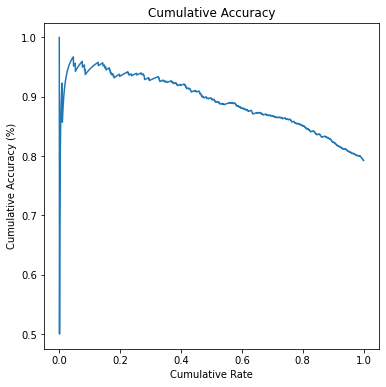

In [16]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

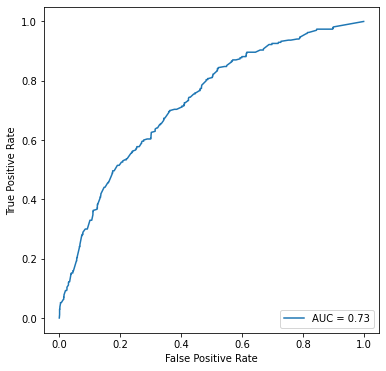

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

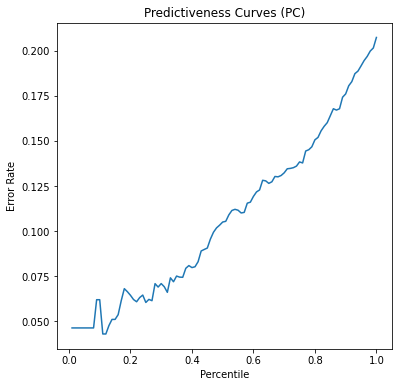

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [19]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.583 vs 0.727



### Distance measure with dm+1e-6

In [20]:
# Step 4: Evaluation with dm+1e-6

dm = 1/(dist_measure+1e-6)

sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dm)
fpr, tpr = roc_ad(y_test, y_pred, dm)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dm)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dm)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.796
Specificity: 0.789


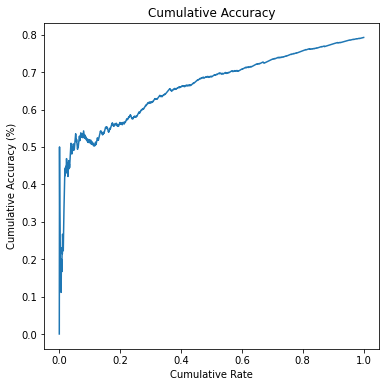

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

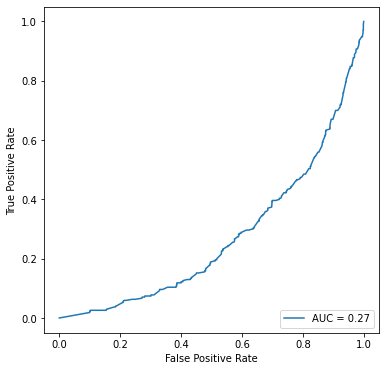

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

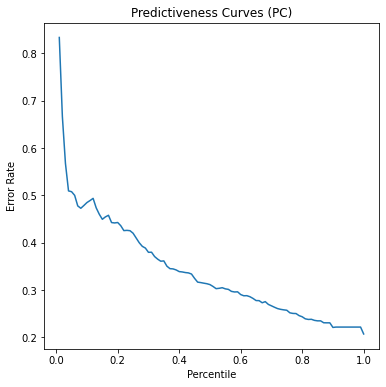

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [24]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.458 vs 0.273



## ProbabilityClassifier for Support Vector Machines

In [25]:
svm_train_acc = svc.score(X_train, y_train)
svm_test_acc = svc.score(X_test, y_test)
print("Support Vector Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {svm_train_acc*100:.2f}%, test: {svm_test_acc*100:.2f}%\n')

Support Vector Classifier with Probability Classifier
[Accuracy] Train: 97.37%, test: 78.03%



In [26]:
# Step 3: Train App Domain
sv_ad = ProbabilityClassifier(clf=svc)
sv_ad.fit(X_train)

dist_measure = sv_ad.measure(X_test)
y_pred = svc.predict(X_test)

In [27]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.811
Specificity: 0.744


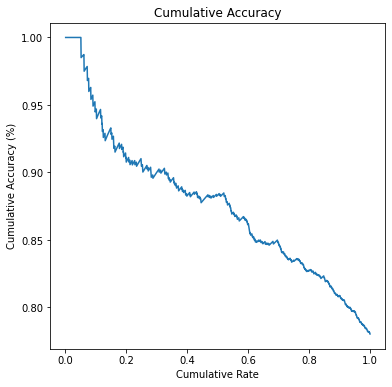

In [28]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

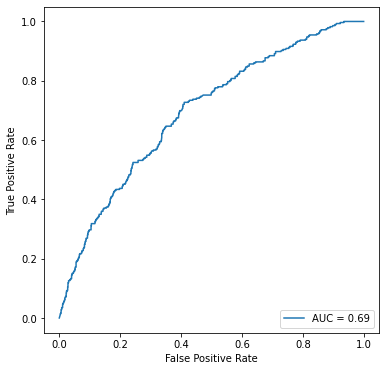

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

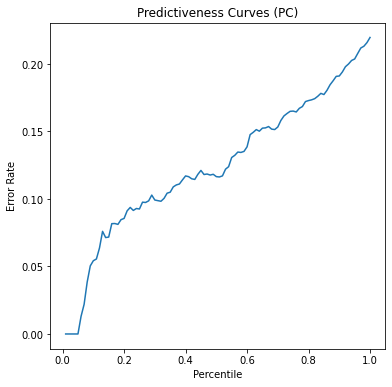

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

In [31]:
print(f"permutationAUC vs auc(roc_ad) of AMES for split1:")
print("====================================================")
print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")

permutationAUC vs auc(roc_ad) of AMES for split1:
         0.549 vs 0.693



## ProbabilityClassifier with K Nearest Neighbors

In [32]:
k_nn_train_acc = k_nn.score(X_train, y_train)
k_nn_test_acc = k_nn.score(X_test, y_test)
print("Support Vector Classifier with Probability Classifier")
print("=============================================================")
print(f'[Accuracy] Train: {k_nn_train_acc*100:.2f}%, test: {k_nn_test_acc*100:.2f}%\n')

Support Vector Classifier with Probability Classifier
[Accuracy] Train: 84.74%, test: 76.34%



In [33]:
# Step 3: Train App Domain
knn_ad = ProbabilityClassifier(clf=k_nn)
knn_ad.fit(X_train)

dist_measure = knn_ad.measure(X_test)
y_pred = k_nn.predict(X_test)

In [34]:
# Step 4: Evaluation
sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
auc_roc = auc(fpr, tpr)

print(f'Sensitivity: {sensitivity:.3f}')
print(f'Specificity: {specificity:.3f}')

Sensitivity: 0.800
Specificity: 0.721


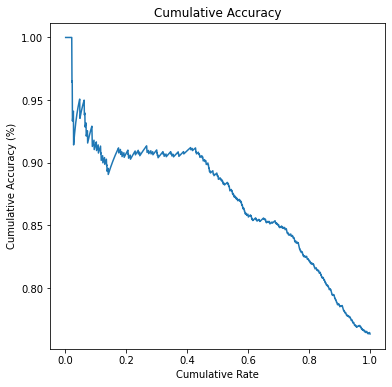

In [35]:
plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy")
plt.show()

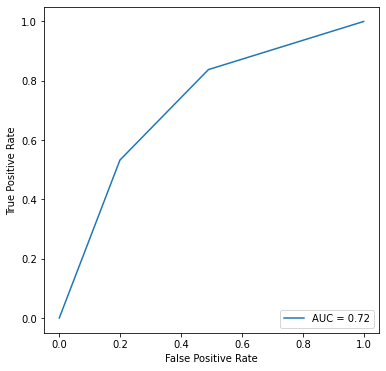

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot(ax=ax)
plt.show()

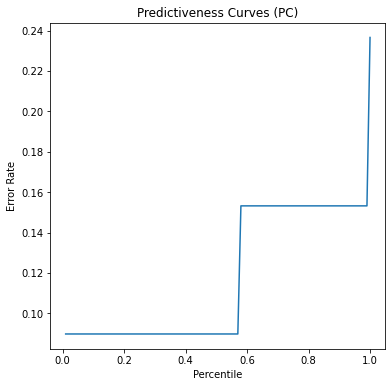

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, err_rate)
ax.set_xlabel("Percentile")
ax.set_ylabel("Error Rate")
ax.set_title("Predictiveness Curves (PC)")
plt.show()

## Check all CV Splits and save results

In [38]:
def runAD(dataset, cv_train, cv_test, clf, ad, name, path=None, scale=True):
    #set up ad, scaler, and path
    ad.clf = clf
    scaler = StandardScaler()
    if path == None:
        path = os.getcwd()
    
    #Get X and y
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values
    size = X.shape[0]
    
    #Prepare DataFrames for evaluation and score data
    measure = pd.DataFrame()
    evaluation = pd.DataFrame()
    evaluations = []
    
    #Test ad for all cv
    for col in cv_train:
        #Find indexes
        train_idx = cv_train[col].dropna(axis=0).to_numpy().astype(int)
        test_idx = cv_test[col].dropna(axis=0).to_numpy().astype(int)
        
        #Scale train and test datasets
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        if scale:
            
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        #Train AD and classifier
        ad.clf.fit(X_train, y_train)
        ad.fit(X_train)
        
        #Gather scores and save them in csv
        dist_measure = ad.measure(X_test)
        new_col = pd.DataFrame(np.around(dist_measure, decimals=6), columns=[col])
        measure = pd.concat([measure, new_col], axis=1)
        
        #Start gathering data from evaluation functions
        y_pred = ad.clf.predict(X_test)
        
        sensitivity, specificity = sensitivity_specificity(y_test, y_pred)
        cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dist_measure)
        fpr, tpr = roc_ad(y_test, y_pred, dist_measure)
        auc_signi, auc_perm = permutation_auc(y_test, y_pred, dist_measure)
        percentile, err_rate = predictiveness_curves(y_test, y_pred, dist_measure)
        auc_roc = auc(fpr, tpr)
        
        #Compare AUCs
        print(f"permutationAUC vs auc(roc_ad) of {name} for {col}:")
        print("==================================================================")
        print(f"         {auc_signi:.3f} vs {auc_roc:.3f}\n")
        
        
        #Create graphs to save for each split
        fig, axes = plt.subplots(2,2,figsize=(6,6))
        axes[0, 0].plot(cumulative_rate, cumulative_acc)
        axes[0, 0].set_title("Cumulative Accuracy")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=auc_roc)
        roc_display.plot(ax=axes[0, 1])
        axes[0, 1].set_title("AUC ROC")
        axes[1, 0].plot(percentile, err_rate)
        axes[1, 0].set_title("Predictiveness Curves (PC)")
        plt.setp(axes[0, 0], xlabel='Cumulative Rate', ylabel='Cumulative Accuracy (%)')
        plt.setp(axes[1, 0], xlabel='Percentile', ylabel='Error Rate')
        fig.delaxes(axes[1, 1])
        fig.suptitle(f'Graphs of {name} for {col}', fontsize=16)
        fig.tight_layout()
        fig.savefig(f'{os.path.join(path, f"{name}_{col}_graphs.png")}', dpi=300)
        
        #Save evaluation
        column1 = pd.DataFrame([np.round(sensitivity, 6)], columns=['sensitivity'])
        column2 = pd.DataFrame([np.round(specificity, 6)],columns=['specificity'])
        column3 = pd.DataFrame(np.around(cumulative_acc, 6),columns=['cumulative_acc'])
        column4 = pd.DataFrame(np.around(cumulative_rate, 6), columns=['cumulative_rate'])
        column5 = pd.DataFrame(np.around(fpr, 6),columns=['roc_ad_fpr'])
        column6 = pd.DataFrame(np.around(tpr, 6),columns=['roc_ad_tpr'])
        column7 = pd.DataFrame([np.round(auc_roc,6)] ,columns=['auc(roc_ad)'])
        column8 = pd.DataFrame([np.round(auc_signi, 6)],columns=['permutation_auc'])
        column9 = pd.DataFrame(np.around(auc_perm,6),columns=['permutation_list'])
        column10 = pd.DataFrame(np.around(percentile, 6),columns=['pred_curve_percent'])
        column11 = pd.DataFrame(np.around(err_rate, 6),columns=['pred_curve_err'])
        
        evaluation = pd.concat([column1, column2, column3, column4, column5, column6, column7, column8, column9, column10, column11],axis=1)
        evaluation.to_csv(os.path.join(path, f'{name}_{col}_evaluation.csv'), index=False)
        evaluations.append(evaluation)
    
    measure.to_csv(os.path.join(path, f'{name}_scores.csv'), index=False)
    
    return evaluations

## All RFC Results

permutationAUC vs auc(roc_ad) of Ames_rf for cv1:
         0.584 vs 0.727

permutationAUC vs auc(roc_ad) of Ames_rf for cv2:
         0.576 vs 0.700

permutationAUC vs auc(roc_ad) of Ames_rf for cv3:
         0.586 vs 0.724

permutationAUC vs auc(roc_ad) of Ames_rf for cv4:
         0.585 vs 0.685

permutationAUC vs auc(roc_ad) of Ames_rf for cv5:
         0.587 vs 0.720



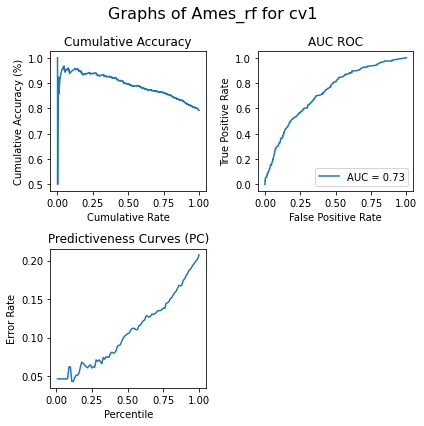

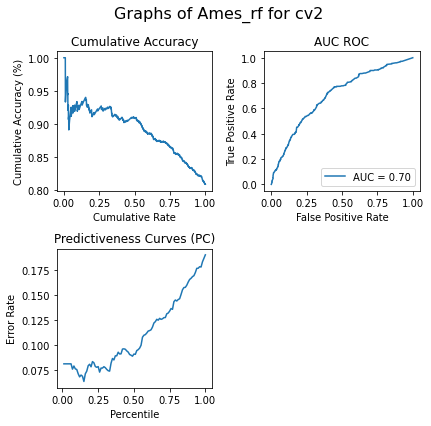

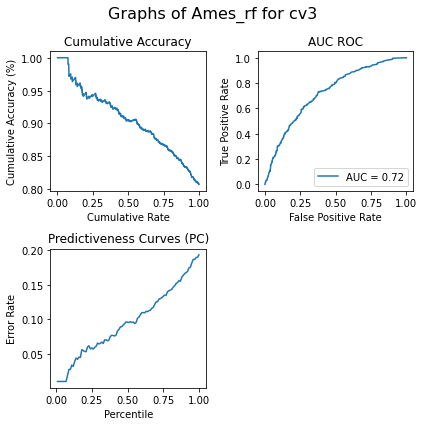

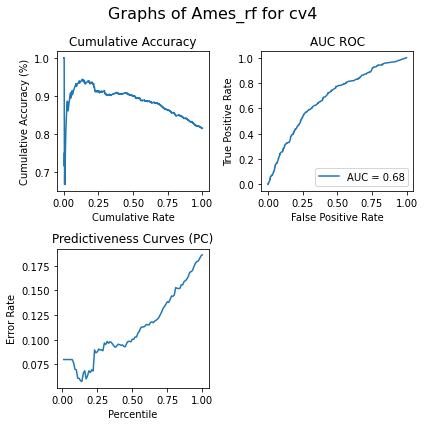

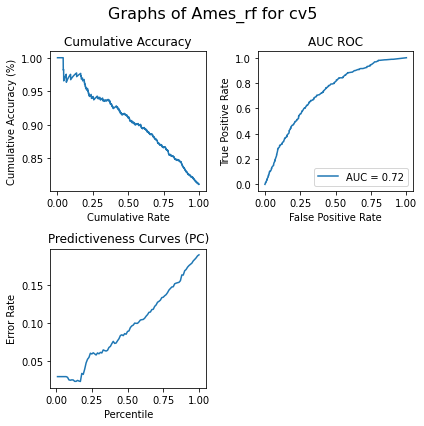

In [39]:
path = os.path.join(PATH_ROOT, 'results')
rf_evaluation = runAD(data, idx_train, idx_test, rfc, rf_ad, "Ames_rf", path)

## All SVC Results

permutationAUC vs auc(roc_ad) of Ames_svm for cv1:
         0.549 vs 0.693

permutationAUC vs auc(roc_ad) of Ames_svm for cv2:
         0.546 vs 0.703

permutationAUC vs auc(roc_ad) of Ames_svm for cv3:
         0.553 vs 0.685

permutationAUC vs auc(roc_ad) of Ames_svm for cv4:
         0.559 vs 0.685

permutationAUC vs auc(roc_ad) of Ames_svm for cv5:
         0.551 vs 0.718



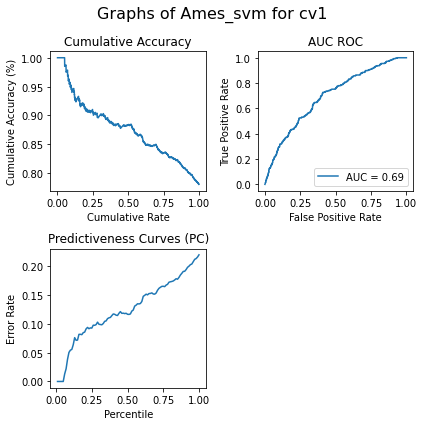

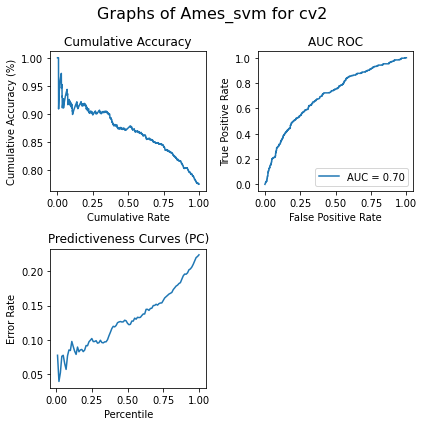

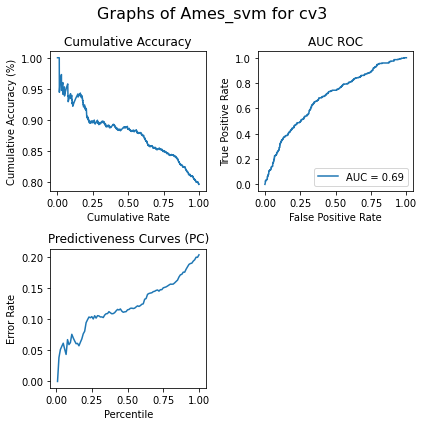

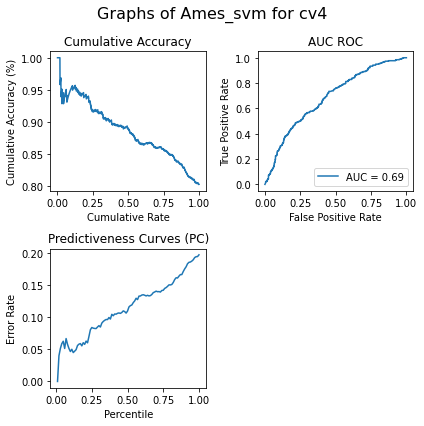

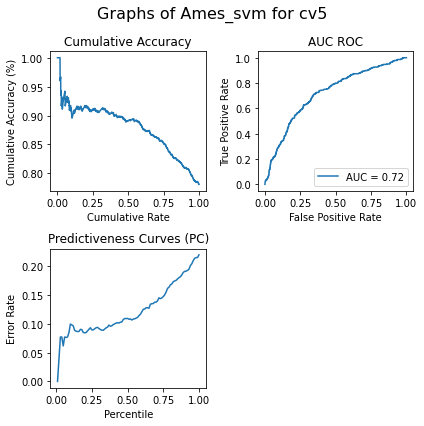

In [40]:
svc_evaluation = runAD(data, idx_train, idx_test, svc, sv_ad, "Ames_svm", path)

## All k-NN Results

permutationAUC vs auc(roc_ad) of Ames_knn for cv1:
         0.531 vs 0.721

permutationAUC vs auc(roc_ad) of Ames_knn for cv2:
         0.546 vs 0.691

permutationAUC vs auc(roc_ad) of Ames_knn for cv3:
         0.545 vs 0.696

permutationAUC vs auc(roc_ad) of Ames_knn for cv4:
         0.558 vs 0.690

permutationAUC vs auc(roc_ad) of Ames_knn for cv5:
         0.546 vs 0.702



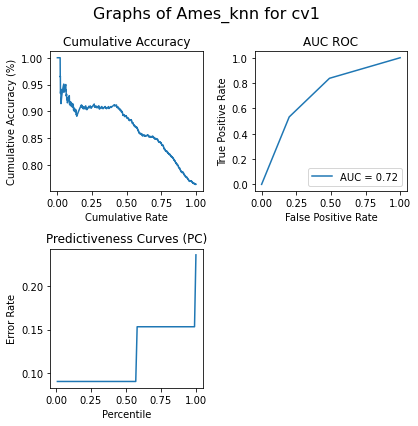

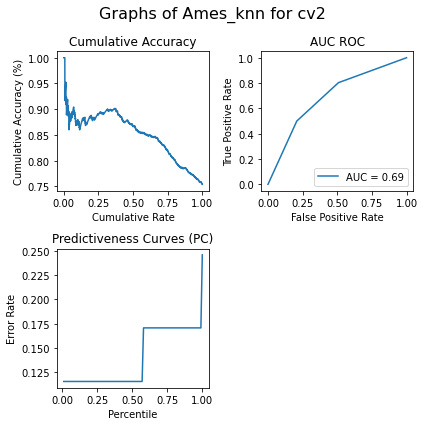

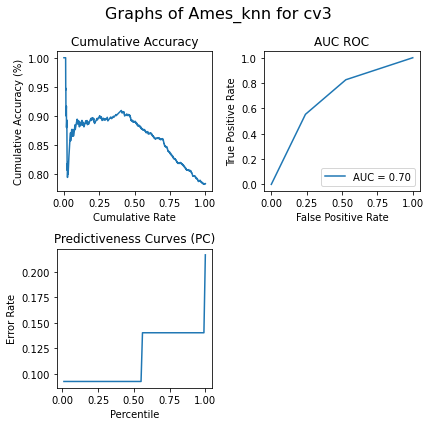

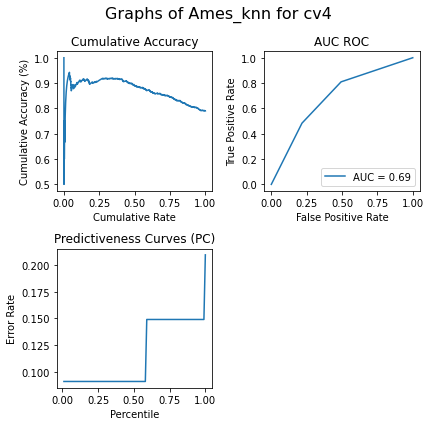

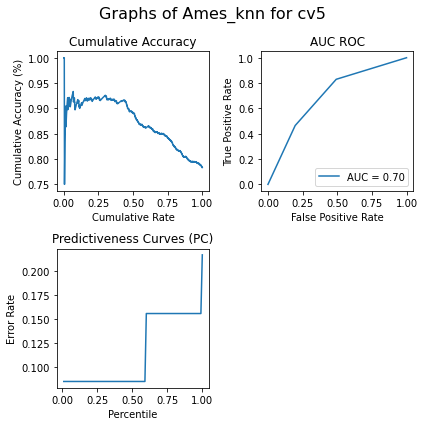

In [41]:
knn_evaluation = runAD(data, idx_train, idx_test, k_nn, knn_ad, "Ames_knn", path)

### Checking Sensitivity and Specificity of all Results

In [42]:
for i in range(len(rf_evaluation)):
    evaluation = rf_evaluation[i]
    print(f'Sensitivity for Random Forest cv{i+1}: {evaluation["sensitivity"][0]}')
    print(f'Specificity for Random Forest cv{i+1}: {evaluation["specificity"][0]}\n')

Sensitivity for Random Forest cv1: 0.795714
Specificity for Random Forest cv1: 0.789037

Sensitivity for Random Forest cv2: 0.81402
Specificity for Random Forest cv2: 0.803987

Sensitivity for Random Forest cv3: 0.799714
Specificity for Random Forest cv3: 0.815615

Sensitivity for Random Forest cv4: 0.809728
Specificity for Random Forest cv4: 0.818937

Sensitivity for Random Forest cv5: 0.82
Specificity for Random Forest cv5: 0.800333



In [43]:
for i in range(len(svc_evaluation)):
    evaluation = svc_evaluation[i]
    print(f'Sensitivity for SVM cv{i+1}: {evaluation["sensitivity"][0]}')
    print(f'Specificity for SVM cv{i+1}: {evaluation["specificity"][0]}\n')

Sensitivity for SVM cv1: 0.811429
Specificity for SVM cv1: 0.744186

Sensitivity for SVM cv2: 0.802575
Specificity for SVM cv2: 0.744186

Sensitivity for SVM cv3: 0.815451
Specificity for SVM cv3: 0.774086

Sensitivity for SVM cv4: 0.81402
Specificity for SVM cv4: 0.790698

Sensitivity for SVM cv5: 0.807143
Specificity for SVM cv5: 0.750416



In [44]:
for i in range(len(knn_evaluation)):
    evaluation = knn_evaluation[i]
    print(f'Sensitivity for k-NN cv{i+1}: {evaluation["sensitivity"][0]}')
    print(f'Specificity for k-NN cv{i+1}: {evaluation["specificity"][0]}\n')

Sensitivity for k-NN cv1: 0.8
Specificity for k-NN cv1: 0.72093

Sensitivity for k-NN cv2: 0.771102
Specificity for k-NN cv2: 0.734219

Sensitivity for k-NN cv3: 0.804006
Specificity for k-NN cv3: 0.759136

Sensitivity for k-NN cv4: 0.801144
Specificity for k-NN cv4: 0.777409

Sensitivity for k-NN cv5: 0.815714
Specificity for k-NN cv5: 0.745424

